# Content Based Image Retrieval

## Downloading data

In [1]:
%%bash
wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B4KI-B-t3wTjbElMTS1DVldQUnc' -O Jewellery.tar.gz
tar xf Jewellery.tar.gz
rm Jewellery/*.gz
rm Jewellery/*.zip

--2020-02-10 06:21:08--  https://docs.google.com/uc?export=download&id=0B4KI-B-t3wTjbElMTS1DVldQUnc
Resolving docs.google.com (docs.google.com)... 172.217.214.101, 172.217.214.102, 172.217.214.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p3a83f7btjc9kumd51u3fbhmt08dk9oh/1581315300000/05745446626127446636/*/0B4KI-B-t3wTjbElMTS1DVldQUnc?e=download [following]
--2020-02-10 06:21:13--  https://doc-0k-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p3a83f7btjc9kumd51u3fbhmt08dk9oh/1581315300000/05745446626127446636/*/0B4KI-B-t3wTjbElMTS1DVldQUnc?e=download
Resolving doc-0k-a8-docs.googleusercontent.com (doc-0k-a8-docs.googleusercontent.com)... 173.194.194.132, 2607:f8b0:4001:c10::84
Connecting to doc-0k-a8-docs.googleusercontent.com (doc-0k-a8-docs.google

## Importing modules

In [0]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from PIL import Image


## Viewing images

Bracelet:



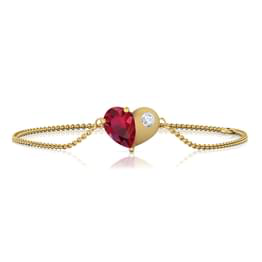

In [3]:
print('Bracelet:\n')
Image.open('Jewellery/bracelet/bracelet_001.jpg')

Ring:



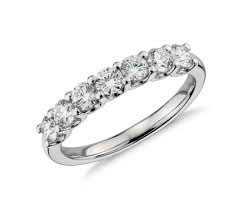

In [4]:
print('Ring:\n')
Image.open('Jewellery/ring/ring_001.jpg')

Earring:



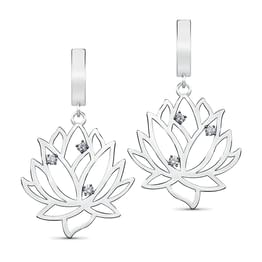

In [5]:
print('Earring:\n')
Image.open('Jewellery/earring/earring_1.jpg')

necklace:



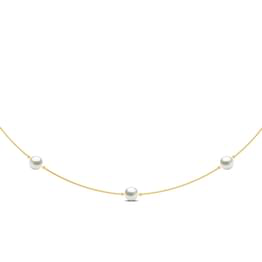

In [6]:
print('necklace:\n')
Image.open('Jewellery/necklace/necklace_1.jpg')

## Create a database

Here we will make a slight modification to the ImageFolder class to retrieve the name of the file as well. Hence we will inherit the ImageFolder class.

In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    Source: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


## Preprocessing the images

In [0]:
transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
dataset = ImageFolderWithPaths('Jewellery', transforms_) # our custom dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

## Downloading a pretrained model

In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We will use the output of the last pooling layers to create the image descriptors

In [0]:
def pooling_output(x):
    global model
    for layer_name, layer in model._modules.items():
        x = layer(x)
        if layer_name == 'avgpool':
            break
    return x

## Extracting features

In [0]:
# iterate over data
image_paths = []
descriptors = []
model.to(DEVICE)
with torch.no_grad():
    model.eval()
    for inputs, labels, paths in dataloader:
        result = pooling_output(inputs.to(DEVICE))
        descriptors.append(result.cpu().view(1, -1).numpy())
        image_paths.append(paths)
        torch.cuda.empty_cache()

In [12]:
len(image_paths)

1271

In [13]:
image_paths[:5]

[('Jewellery/bracelet/bracelet_001.jpg',),
 ('Jewellery/bracelet/bracelet_002.jpg',),
 ('Jewellery/bracelet/bracelet_003.jpg',),
 ('Jewellery/bracelet/bracelet_004.jpg',),
 ('Jewellery/bracelet/bracelet_005.jpg',)]

In [14]:
descriptors[0]

array([[0.67533237, 0.28646162, 0.23659411, ..., 0.08307119, 0.45185536,
        0.27218983]], dtype=float32)

In [15]:
descriptors[0].shape

(1, 2048)

## Installing `faiss`

In [16]:
!wget https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl

--2020-02-10 06:21:50--  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5c18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5a15c9cc393ec612061f033a/5ac54beae586bb11ec0ace46?response-content-disposition=attachment%3B%20filename%3D%22faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20200210T062151Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEFEaCXVzLWVhc3QtMSJIMEYCIQCdWAzS3ECuRfWMfXX0NBxVp%2BWmk65l1uPv3ZtVx6jEzgIhAJ37H6tPZuG40iBRIgFu%2BKkmnWKyGxQcvY7xNU5qulWBKr0DCPn%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEQABoMNDU1ODY0MDk4Mzc

## Create a faiss index

In [0]:
import numpy as np
import faiss


index = faiss.IndexFlatL2(2048)
descriptors = np.vstack(descriptors)
index.add(descriptors)

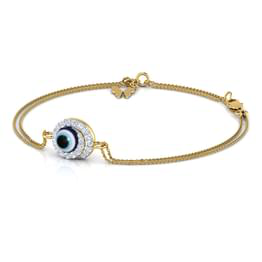

In [18]:
query_image = 'Jewellery/bracelet/bracelet_048.jpg'
img = Image.open(query_image)
img

In [0]:
input_tensor = transforms_(img)
input_tensor = input_tensor.view(1, *input_tensor.shape)
with torch.no_grad():
    query_descriptors = pooling_output(input_tensor.to(DEVICE)).cpu().numpy()
    distance, indices = index.search(query_descriptors.reshape(1, 2048), 9)


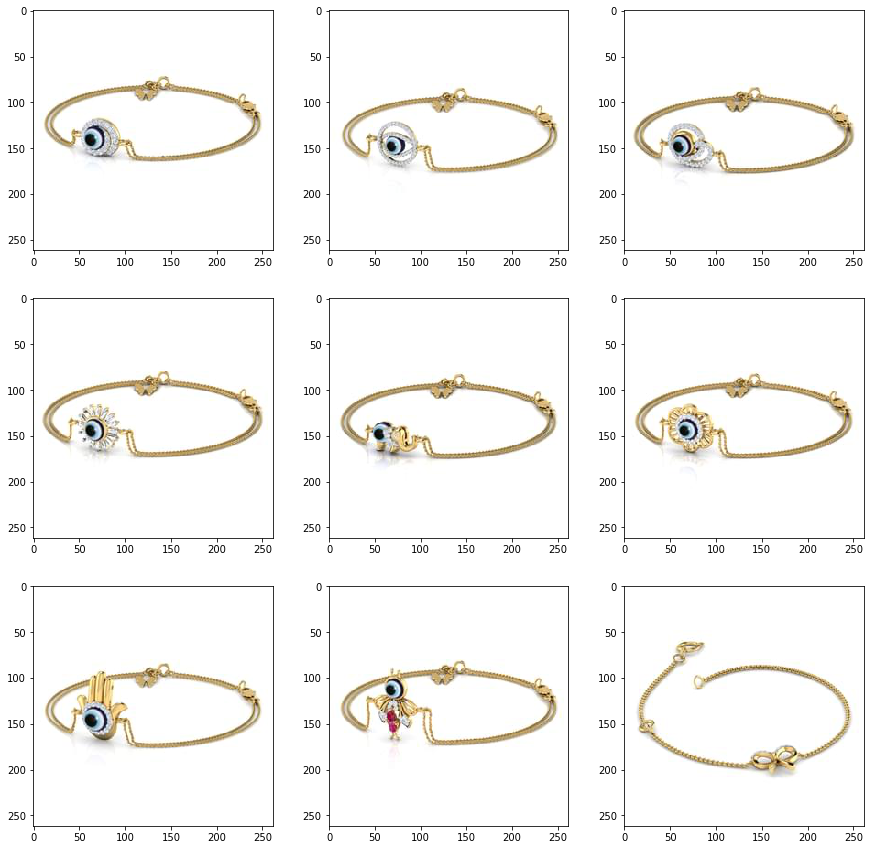

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
    ax_i.imshow(plt.imread(image_paths[file_index][0]))

plt.show()